In [1]:

%pylab inline

import tensorflow as tf
%matplotlib inline
import numpy as np
from collections import deque
from os import listdir
import functools


import pylab
from tsne import bh_sne
from matplotlib import pyplot as plt
import pandas
import scipy
import numpy as np
import sklearn.manifold
import os
import gc
from time import gmtime, strftime
import seaborn as sns
from os import listdir
from os.path import isfile, join
import math
from scipy.stats.stats import pearsonr
import random as rand
import pyproj
import functools
import pickle
import random


image_width = 128

def display(image, min = 0.0, max = 1.0):
    plt.imshow(image, cmap = plt.get_cmap('gray'), interpolation='nearest')
    plt.show()
    
    
def memoize(obj, maxlen = 2000):
    """A decorator to cache advice objects using the advice key"""
    cache = obj.cache = {}
    deck = obj.deck = deque([], maxlen = maxlen)

    @functools.wraps(obj)
    def memoizer(*args, **kwargs):
        key = args[0]
        if key not in cache:
            if len(deck) == deck.maxlen:
              del cache[deck.popleft()[0]]
            temp = obj(*args, **kwargs)
            cache[key] = temp
            deck.append((key, temp))
        return cache[key]
        
    return memoizer

@memoize
def load_mat_from_file(key):
    f = file("/home/isaac/Desktop/devika/ARCGIS/ArcGis/pickle_files/"+key+".npy","rb")
    return np.load(f)

@memoize
def get_file_containing(housex, housey):
#         print "house coords:", housex, housey
    for key in file_attributes:
        block = file_attributes[key]
    #         print block['xllcorner'], block['yllcorner']
        if block['xllcorner'] < housex < block['xllcorner'] + block['width']:
            if block['yllcorner'] < housey < block['yllcorner'] + block['height']:
                return key
    assert(1==0)

def imagex(housex, housey, block):
    return (int(housex)-block['xllcorner'])/5
def imagey(housex, housey, block):
    return (int(housey)-block['yllcorner'])/5



#housex and housey in meters
def get_heightmap_around(housex, housey, window_width_pixels = 28):
    
    def image_slice(key, housex, housey, radius = window_width_pixels/2):
        x = housex
        y = housey
        block = file_attributes[key]
        mat = load_mat_from_file(key)
        x1 = np.max([0,              imagex(x,y,block) - radius])
        x2 = np.min([block['ncols'], imagex(x,y,block) + radius])
        
        y1 = np.max([0,              imagey(x,y,block) - radius])
        y2 = np.min([block['nrows'], imagey(x,y,block) + radius])
        
        assert(x1 <= x2)
        assert(y1 <= y2)
        return  mat[block['nrows'] - y2:block['nrows'] - y1, x1:x2]
    
    window_width_feet = window_width_pixels * 5
    housex /= .3048 #convert to feet
    housey /= .3048
    x = housex
    y = housey
    ul = get_file_containing(x - window_width_feet/2, y - window_width_feet/2)
    ur = get_file_containing(x + window_width_feet/2, y - window_width_feet/2)
    ll = get_file_containing(x - window_width_feet/2, y + window_width_feet/2)
    lr = get_file_containing(x + window_width_feet/2, y + window_width_feet/2)

    for key in [ul, ur, ll, lr]:
        image = image_slice(key, x, y)
#         print image.shape
        if image.shape == (window_width_pixels, window_width_pixels):
            return image

    

    if ul == ur and lr == ll : # horizontal split


        result = np.zeros([window_width_pixels, window_width_pixels])
        upper_slice = image_slice(ul, housex, housey)
        lower_slice = image_slice(ll, housex, housey)
        
        result[:upper_slice.shape[0], :] = upper_slice
        result[ window_width_pixels - lower_slice.shape[0]:, :] = lower_slice


        return result
    elif ul == ll and ur == lr and ul != ur and ll != lr: # vertical split
        result = np.zeros([window_width_pixels, window_width_pixels])
        left_slice = image_slice(ll, housex, housey)
        right_slice = image_slice(ur, housex, housey)
#         print left_slice.shape
#         print right_slice.shape
        
        result[:, :left_slice.shape[1]] = left_slice
        result[:, window_width_pixels - right_slice.shape[1]:] = right_slice

#         plt.imshow(result)
#         plt.show()
#         display(result)

        return result
    else: # four way split
#         print "four way"
        ll_slice = image_slice(ll, housex, housey)
        ul_slice = image_slice(ul, housex, housey)
        lr_slice = image_slice(lr, housex, housey)
        ur_slice = image_slice(ur, housex, housey)
        
        result = np.zeros([window_width_pixels, window_width_pixels])
        result[:ll_slice.shape[0], :ll_slice.shape[1]] = ll_slice
        result[:lr_slice.shape[0], window_width_pixels - lr_slice.shape[1]:] = lr_slice
        
        result[window_width_pixels - ul_slice.shape[0]:, :ul_slice.shape[1]] = ul_slice
        result[window_width_pixels - ur_slice.shape[0]:, window_width_pixels - ur_slice.shape[1]:] = ur_slice
#         display(result)
        return result

        

def window_violated_chunk_borders(housex, housey):
    corners = [(housex-window_width_feet/2, housey-window_width_feet/2),
              (housex-window_width_feet/2, housey+window_width_feet/2),
              (housex+window_width_feet/2, housey+window_width_feet/2),
              (housex+window_width_feet/2, housey-window_width_feet/2)]
    files = map(lambda x: get_file_containing(x[0], x[1]), corners)
    return len(set(files)) > 1



file_attributes = {}

mypath = "/home/isaac/Desktop/devika/ARCGIS/ArcGis/ascii_files"
for filename in [f for f in listdir(mypath) if isfile(join(mypath, f))]: 
    attributes = {}
    with open(mypath + "/" + filename) as FileObj:
        for index, line in enumerate(FileObj):
            if(index < 6):
#                 print line
                attributes[line.split(" ")[0]] = int(line.split(" ")[-1][:-2])
            else:
                break # don't load the other lines into memory becuase that's a waste of time.

    attributes['width'] = attributes['ncols'] * attributes['cellsize']
    attributes['height'] = attributes['nrows'] * attributes['cellsize']
    file_attributes[filename] = attributes
print "loaded all file header attributes into dict"


def load_data(path, normalize_columns = False, only_columns_containing = ""):
    print("loading...")
    gc.collect() # collect garbage
    data = pandas.read_hdf(path, '/df')
    df = pandas.DataFrame(data)
    df = df.sort(['hcad']).fillna(0)
    df = df.reset_index()#(ascending=True)

    data_dict = {}
    for label in set(df._get_numeric_data().columns).union({'hcad'}):
        # union hcad to ensure that hcad col comes in even if not considered numerical
        if normalize_columns and  label != 'hcad':
            column_data = np.array(df[label].astype(float))
            column_data -= np.min(column_data)
            data_dict[label] = column_data / np.max(column_data)
        elif label != 'hcad':
            data_dict[label] = df[label].astype(float)

    result = pandas.DataFrame.from_dict(data_dict)

    result = result.replace([np.inf, -np.inf], 1)
    
    
    for label in result:
        if not only_columns_containing in str(label):
            result.drop([str(label)], axis = 1 , inplace= True)

    return result


wind_data = load_data("/home/isaac/Dropbox/data_for_brian/wind_features/hcad_interp_withoutpartial_rad100_hist8x8.mat.hd", 
              normalize_columns=True, only_columns_containing = "spd")
meta = load_data("/home/isaac/Dropbox/data_for_brian/meta/df_meta.hd")
y_data = load_data("/home/isaac/Dropbox/data_for_brian/y_df.hd")
hcad = load_data("/home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df_point.hd", 
              normalize_columns=True)
# wind_data = wind_data[meta['img0'] == 1]
# y_data = wind_data[meta['img0'] == 1]
y_gaussian = pickle.load(open( "/home/isaac/Desktop/house_guassian_damage_balance.p", "rb" ) )

wgs84=pyproj.Proj("+init=EPSG:4326") # LatLon with WGS84 datum used by GPS units and Google Earth
UTM26N=pyproj.Proj("+init=EPSG:2278") # UTM coords, zone Texas Central, WGS84 datum



# metamat, extra_features, regression_y, cat_y = get_batch(1, random = False, start_index=12314)

# meta = load_data("/home/isaac/Dropbox/data_for_brian/meta/df_meta.hd")

# X, _, _ = get_batch(100)
# plt.imshow(X[0,:,:,0])
# plt.show()
# X = X[:,:,:,0].reshape([-1])
# print np.min(X)
# plt.hist(X, bins = 50)
# plt.show()
hcad = np.array(hcad)
wind_data = np.array(wind_data)


# convert hcad to nice log scale
for i in range(hcad.shape[1]):
    hcad[:,i] = log(hcad[:,i] + .001)
    hcad[:,i] -= np.min(hcad[:,i])
    hcad[:,i] /= np.max(hcad[:,i])



Populating the interactive namespace from numpy and matplotlib
loaded all file header attributes into dict
loading...
Opening /home/isaac/Dropbox/data_for_brian/wind_features/hcad_interp_withoutpartial_rad100_hist8x8.mat.hd in read-only mode
loading...
Opening /home/isaac/Dropbox/data_for_brian/meta/df_meta.hd in read-only mode
loading...
Opening /home/isaac/Dropbox/data_for_brian/y_df.hd in read-only mode
loading...
Opening /home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df_point.hd in read-only mode


In [2]:
housewise_square_damage_actual = np.array(pickle.load( open( "housewise_square_damage_actual.p", "rb" ) ))
print housewise_square_damage_actual


[ 0.06857143  0.06857143  0.06857143 ...,  0.11111111  0.51248163
  0.51248163]


In [3]:


def get_batch(batch_size = 100, randomize = True, start_index = 0, end_index = len(meta)-1, val = False):
    metamat = np.zeros([batch_size, image_width, image_width, 1]).astype(float32)
    regression_y = np.zeros([batch_size]).astype(float32)
    categorical_y = np.zeros([batch_size]).astype(int32)
    extra_features = np.zeros([batch_size,len(wind_data[0])]).astype(float32)
    i = 0
    while i < batch_size:

        index = (i + start_index)
        if randomize:
            index = rand.randint(0, len(meta)-1) % end_index
            if index % 100 == 0 and not val:
                index +=  rand.randint(1, 99)
                if index > len(meta):
                    index = len(meta) -1
            elif val:
                index -= index % 100
        lon = [meta['lon'][index]]
        lat = [meta['lat'][index]]
        max_wind_speed = np.max(wind_data[index])
        regression_y[i] = housewise_square_damage_actual[index]
        categorical_y[i] = y_data['y'][index]
#         print (categorical_y[i])
#         if random.random() < .725 and categorical_y[i] == 0:
# #         if categorical_y[i] == 0:
#             continue
        
        extra_features[i] = wind_data[index]

        xx, yy = pyproj.transform(wgs84, UTM26N, lon, lat)
        housex=xx[0]
        housey=yy[0]

        lidar = None
        try:
            lidar = get_heightmap_around(housex, housey, window_width_pixels=image_width)
        except:
#             print "oops pham"
            continue
        if(lidar == None):
            continue
        
        lidar = lidar.copy()
#         print lidar
#         plt.imshow(lidar)
#         plt.show()
        lidar = (lidar - np.mean(lidar)) / 50.0 #/ np.std(lidar.flatten())
#         print np.max(lidar), np.min(lidar)
#         print list(lidar[0,:].flatten())

#         print lidar.shape
#         print np.std(lidar, axis = 0) 
#         print np.mean(lidar)
#         plt.imshow(lidar)
#         plt.show()
        lidar[lidar < -50] = -50
#         lidar[lidar >250] = 250
#         lidar /= 250.0
#         lidar -= np.min(lidar)
#         lidar /= np.max(lidar)

        lidar = lidar / np.std(lidar)
        lidar = lidar - np.min(lidar)
        lidar = lidar  / np.max(lidar)
        lidar = lidar * 2 - 1
        metamat[i, :, :, 0] = lidar
        wind_data_channel = np.zeros([image_width, image_width]).astype(float32)
        wind_data_channel.fill(max_wind_speed)
#         metamat[i, :, :, 1] = wind_data_channel
#         break

        i += 1


    return metamat, extra_features, regression_y, np.eye(2)[categorical_y]



In [9]:
import tflearn
tf.reset_default_graph()

X_dim = 784
z_dim = 256
h_dim = 128

def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig


def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)


X = tf.placeholder(tf.float32, shape=[None, 28, 28,1])
z = tf.placeholder(tf.float32, shape=[None, z_dim])
learning_rate_ph = tf.placeholder(tf.float32, name = 'learning_rate')


def sample_z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])


def upsample(images):
    _, width, height, depth = images.get_shape().as_list()
    return tf.image.resize_nearest_neighbor(images, [width*2, height*2], align_corners=None, name=None)




image_width = 28
z_dim = 128
def encoder(X):
    


def generator(z):
    m = z
    m = tflearn.layers.core.fully_connected(m, 1024, activation='LeakyReLU')
    m = tflearn.layers.core.fully_connected(m, 7*7*128, activation='LeakyReLU')
    m = tflearn.layers.core.fully_connected(m, 10*10*128, activation='LeakyReLU')
    m = tflearn.layers.core.fully_connected(m, 10*10*128, activation='LeakyReLU')
    m = tflearn.layers.core.fully_connected(m, image_width**2, activation='tanh')


#     m = tf.reshape(m,[-1,7,7,128])
#     m = tflearn.conv_2d_transpose(m, 128, 5, [image_width/4, image_width/4, 128], strides=1, activation='leakyRelu')
#     m = upsample(m)
#     m = tflearn.conv_2d_transpose(m, 64, 5, [image_width/2, image_width/2, 64], strides=1, activation='leakyRelu')
#     m = upsample(m)
#     m = tflearn.conv_2d_transpose(m, 1, 5, [image_width, image_width, 1], strides=1, activation='tanh')
    m = tf.reshape(m,[-1,image_width,image_width,1])

    return m

    
    
    

def discriminator(x):
    m = tf.reshape(x, shape=[-1, 28, 28, 1])
    m = tflearn.layers.fully_connected(x, image_width * 10, activation = "LeakyReLU")
    m = tflearn.layers.fully_connected(x, 1024, activation = "LeakyReLU")
    m = tflearn.layers.fully_connected(x, 512, activation = "LeakyReLU")

    m = tflearn.layers.fully_connected(x, 256, activation = "LeakyReLU")
    logit = tflearn.layers.fully_connected(m, 1, activation='linear', weights_init = 'xavier')
    return logit
    
    

with tf.variable_scope("gen"):
    G_sample = generator(z)
    
with tf.variable_scope("crit"):
    D_real = discriminator(X)

with tf.variable_scope("crit", reuse=True):
    D_fake = discriminator(G_sample)

D_loss = tf.reduce_mean(D_real) - tf.reduce_mean(D_fake)
G_loss = -tf.reduce_mean(D_fake)



D_solver = (tf.train.RMSPropOptimizer(learning_rate=learning_rate_ph)
            .minimize(-D_loss, var_list= tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='crit')))
G_solver = (tf.train.RMSPropOptimizer(learning_rate=learning_rate_ph)
            .minimize(G_loss, var_list= tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='gen')))

clip_D = [p.assign(tf.clip_by_value(p, -.01, .01)) for p in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='crit')]

sess = tf.Session()
sess.run(tf.initialize_all_variables())

if not os.path.exists('out/'):
    os.makedirs('out/')

i = 0

G_loss_record = []
D_loss_record = []

Instructions for updating:
Use `tf.global_variables_initializer` instead.


Autosaving every 30 seconds


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:42: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Iter: 0; D loss: 0.0; G_loss: -0.0


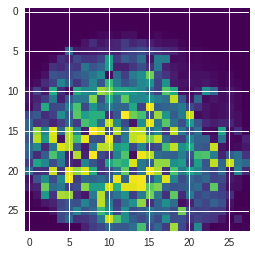

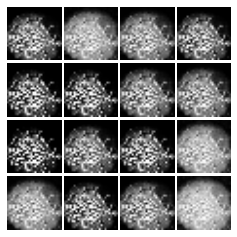

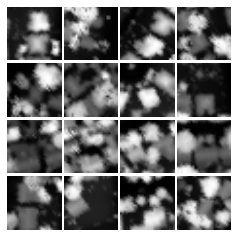

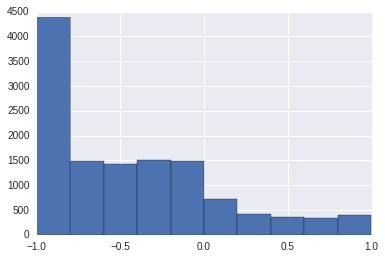

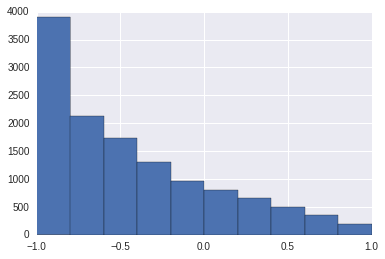

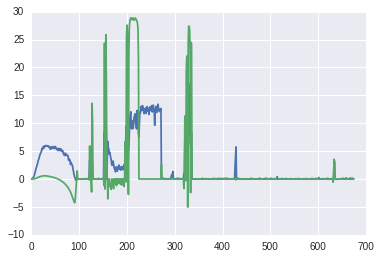

Iter: 100; D loss: 9.816; G_loss: -0.0


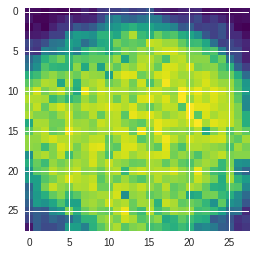

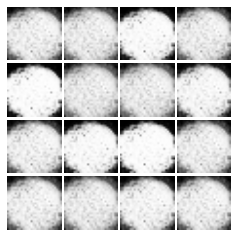

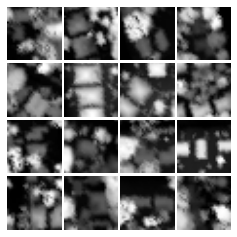

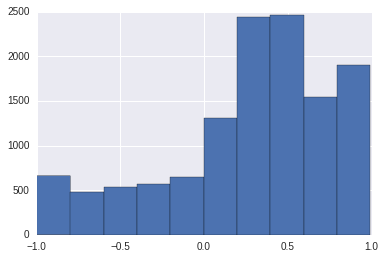

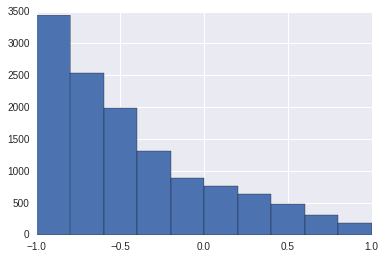

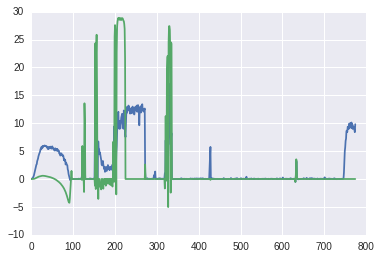

Iter: 200; D loss: 8.672; G_loss: -0.0


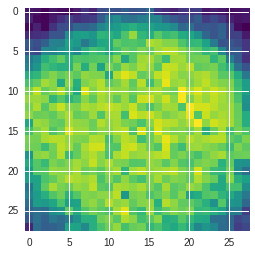

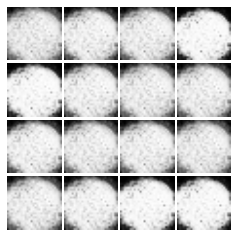

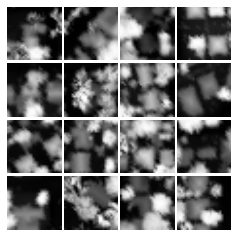

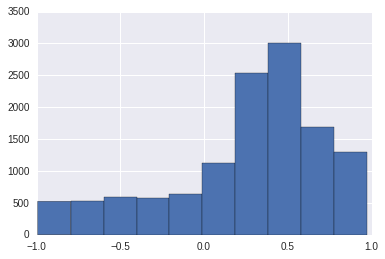

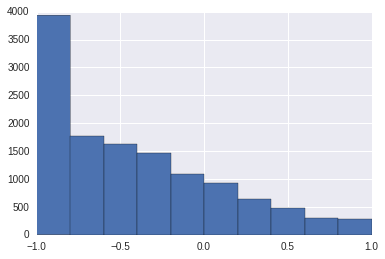

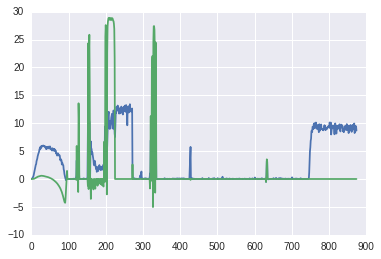

Iter: 300; D loss: 3.314; G_loss: -0.7447


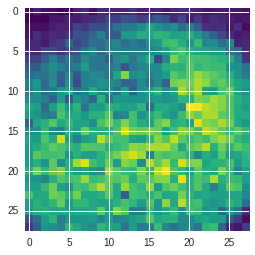

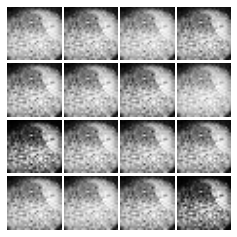

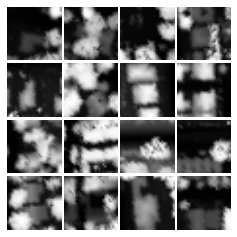

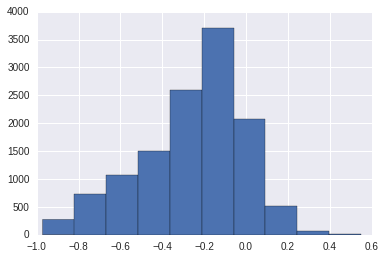

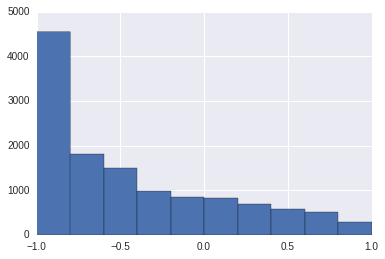

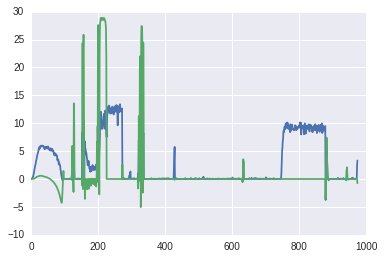

Iter: 400; D loss: 0.6466; G_loss: -0.06058


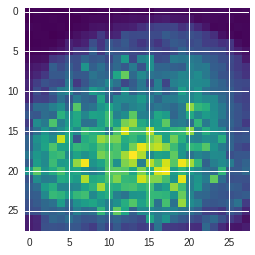

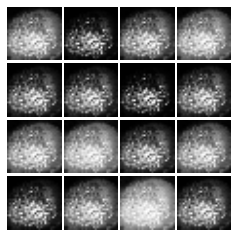

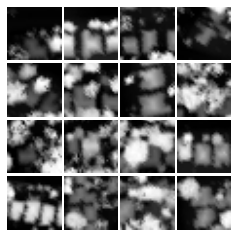

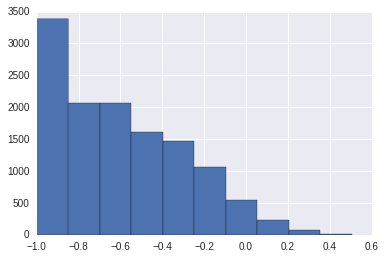

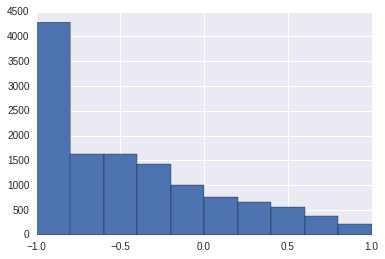

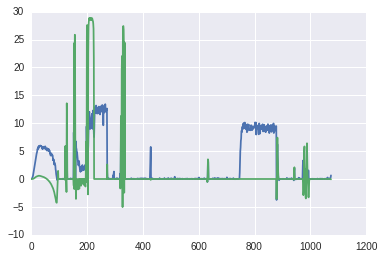

Iter: 500; D loss: 1.085; G_loss: 7.683


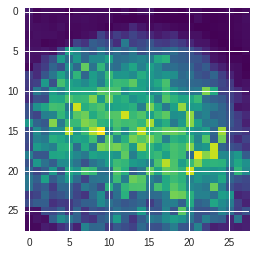

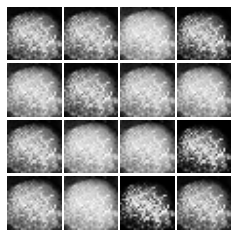

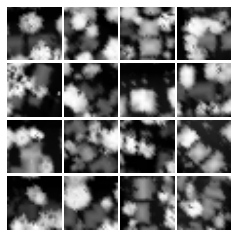

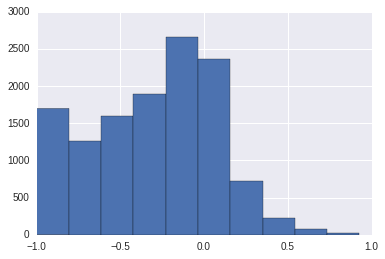

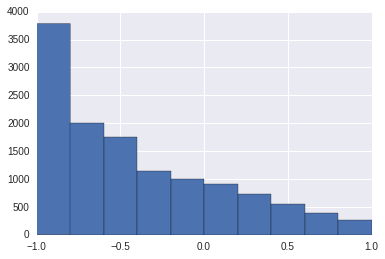

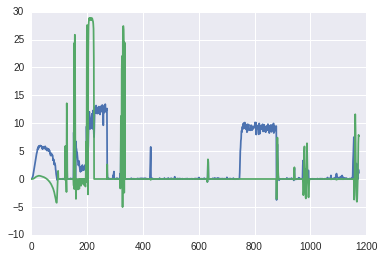

Iter: 600; D loss: 0.0; G_loss: -0.0


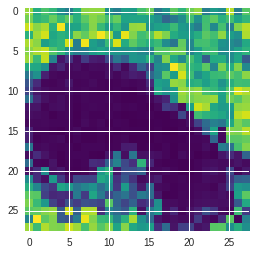

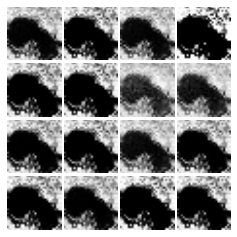

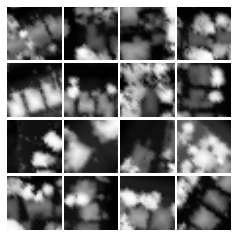

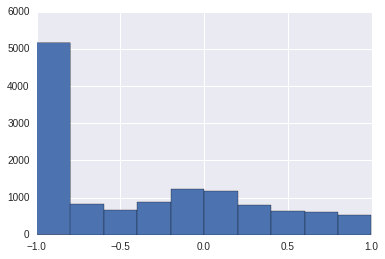

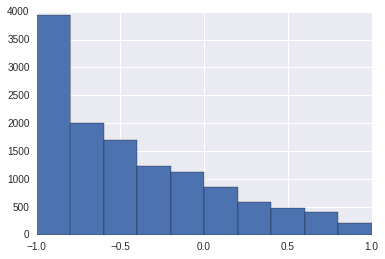

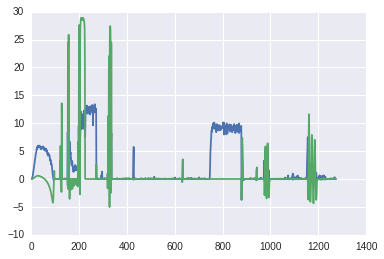

Iter: 700; D loss: -0.149; G_loss: -0.3528


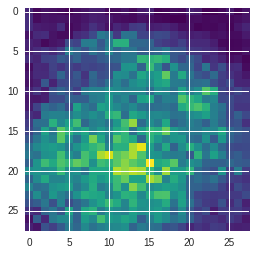

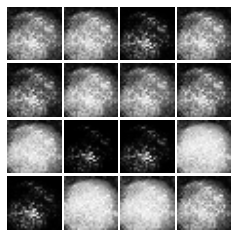

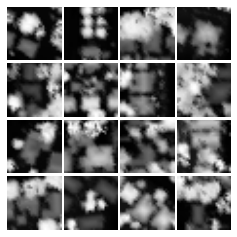

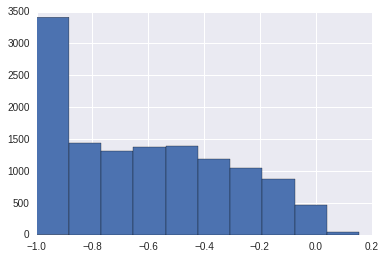

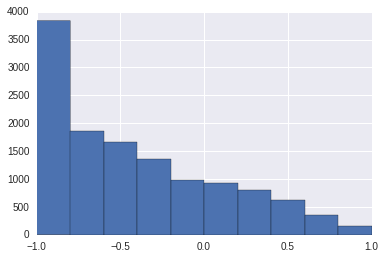

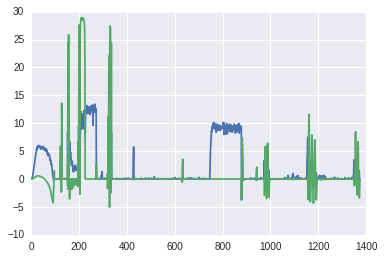

Iter: 800; D loss: 0.3508; G_loss: -0.2553


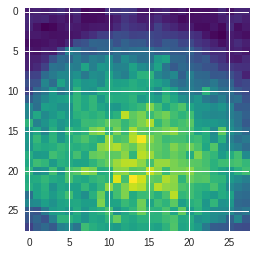

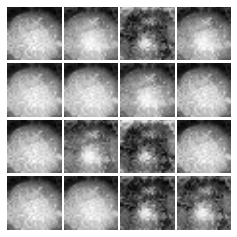

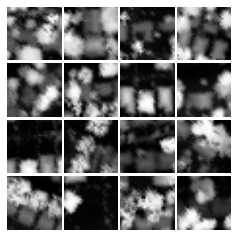

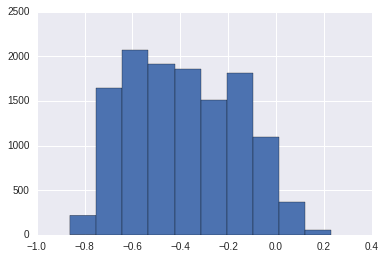

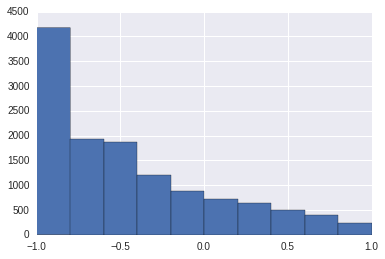

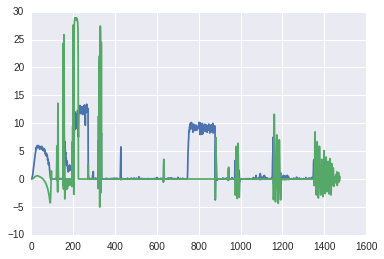

Iter: 900; D loss: 0.0; G_loss: -0.0


/usr/local/lib/python2.7/dist-packages/matplotlib/colors.py:941: UserWarning: Warning: converting a masked element to nan.
  vmin = float(vmin)
/usr/local/lib/python2.7/dist-packages/matplotlib/colors.py:942: UserWarning: Warning: converting a masked element to nan.
  vmax = float(vmax)


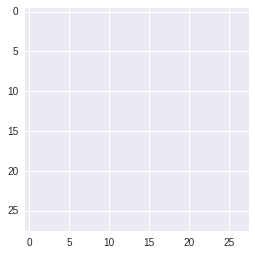

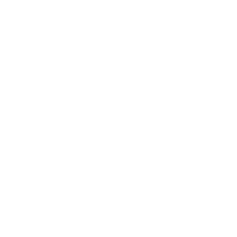

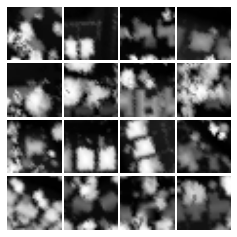

ValueError: max must be larger than min in range parameter.

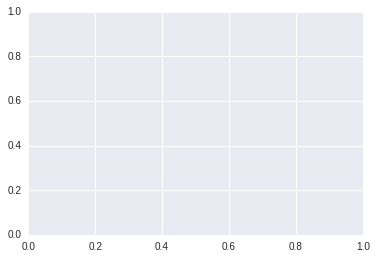

In [13]:
mb_size = 64
import matplotlib.gridspec as gridspec

%autosave 30

%matplotlib inline
for it in range(2000*100):
    D_loss_curr = 100
    i = 0
#     while D_loss_curr > 1 and i < 5:
    for _ in range(10):
        X_mb, _, _, _ = get_batch(mb_size)
#         plt.imshow(X_mb[0, :, :, 0])
#         plt.show()
        X_mb = X_mb.reshape(-1, 28,28,1)
#         plt.hist(X_mb.flatten())
#         plt.show()
        lr = .0002
        
        _, D_loss_curr, _ = sess.run(
            [D_solver, D_loss, clip_D],
            feed_dict={X: X_mb, z: sample_z(mb_size, z_dim), learning_rate_ph: lr}
        )
        i += 1
    D_loss_record.append(D_loss_curr)

    _, G_loss_curr = sess.run(
        [G_solver, G_loss],
        feed_dict={z: sample_z(mb_size, z_dim), learning_rate_ph: lr}
    )
    G_loss_record.append(G_loss_curr)


    if it % 100 == 0:
        print('Iter: {}; D loss: {:.4}; G_loss: {:.4}'
              .format(it, D_loss_curr, G_loss_curr))

        if it % 10 == 0:
            samples = sess.run(G_sample, feed_dict={z: sample_z(16, z_dim)})
            plt.imshow(samples[0, :, :, 0], interpolation ='nearest', cmap = 'viridis')
            plt.show()
            fig = plot(samples)
            fig = plot(X_mb[:16])
            plt.show()
            plt.hist(samples.flatten())
            plt.show()
            plt.hist(X_mb[:16].flatten())
            plt.show()
            i += 1
            plt.show()
            plt.plot(D_loss_record)
#             plt.title("D loss")
#             plt.show()
            plt.plot(G_loss_record)
#             plt.title("G loss")
            plt.show()